### Key Research Question
What did South Korea do right during this pandemic, and what can other countries learn from their response at this initial phase of their coronavirus response? 

# Project Outline 
- Import and inspect data
- Understand the distribution of cases within the country
- Understand the effect of international movement on case numbers
- Understand effects of policies enacted by Korean government
- Breakdown patient mortality across province, age, and gender
- Understand why Daegu is so different from other provinces
- Investigate public tranmission and case clusters
- Make policy recommendations based on findings

### Country Overview

![Korea country overview.png](<attachment:Korea country overview.png>)
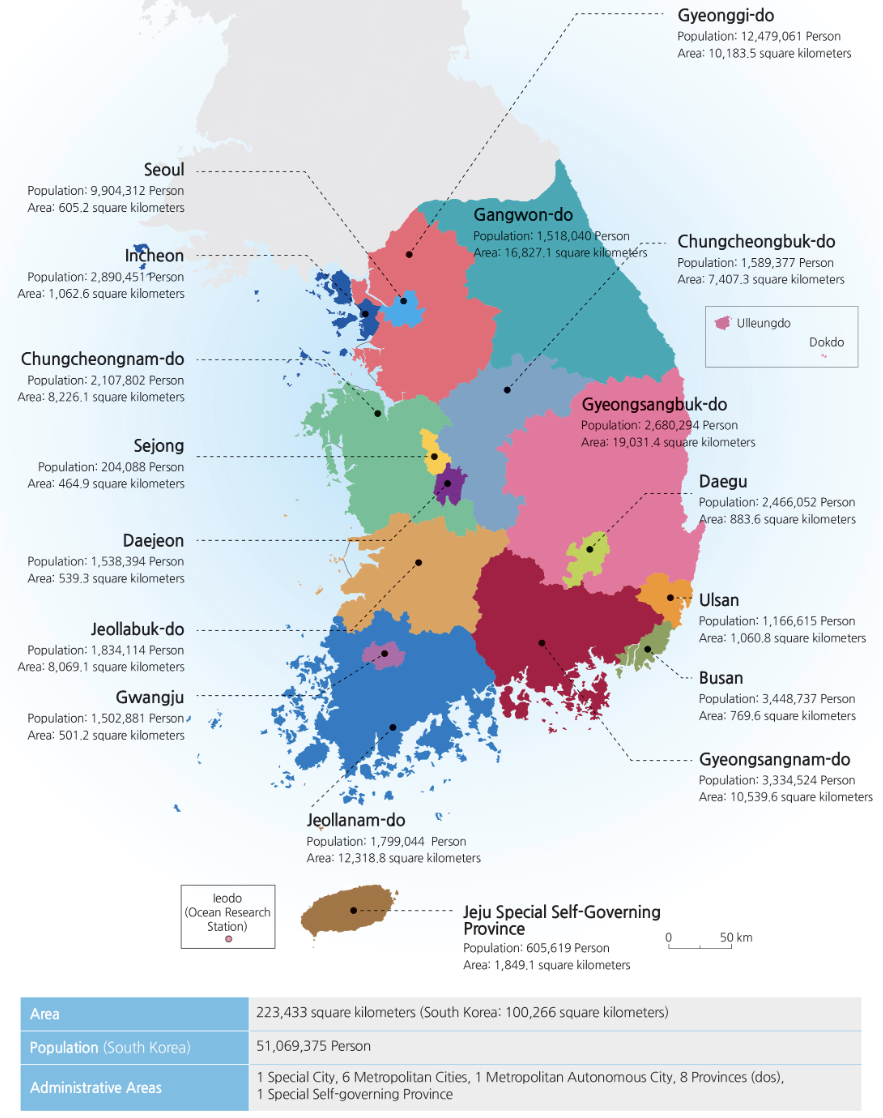

### Dataframe linkages
![Data linkages.png](<attachment:Data linkages.png>)
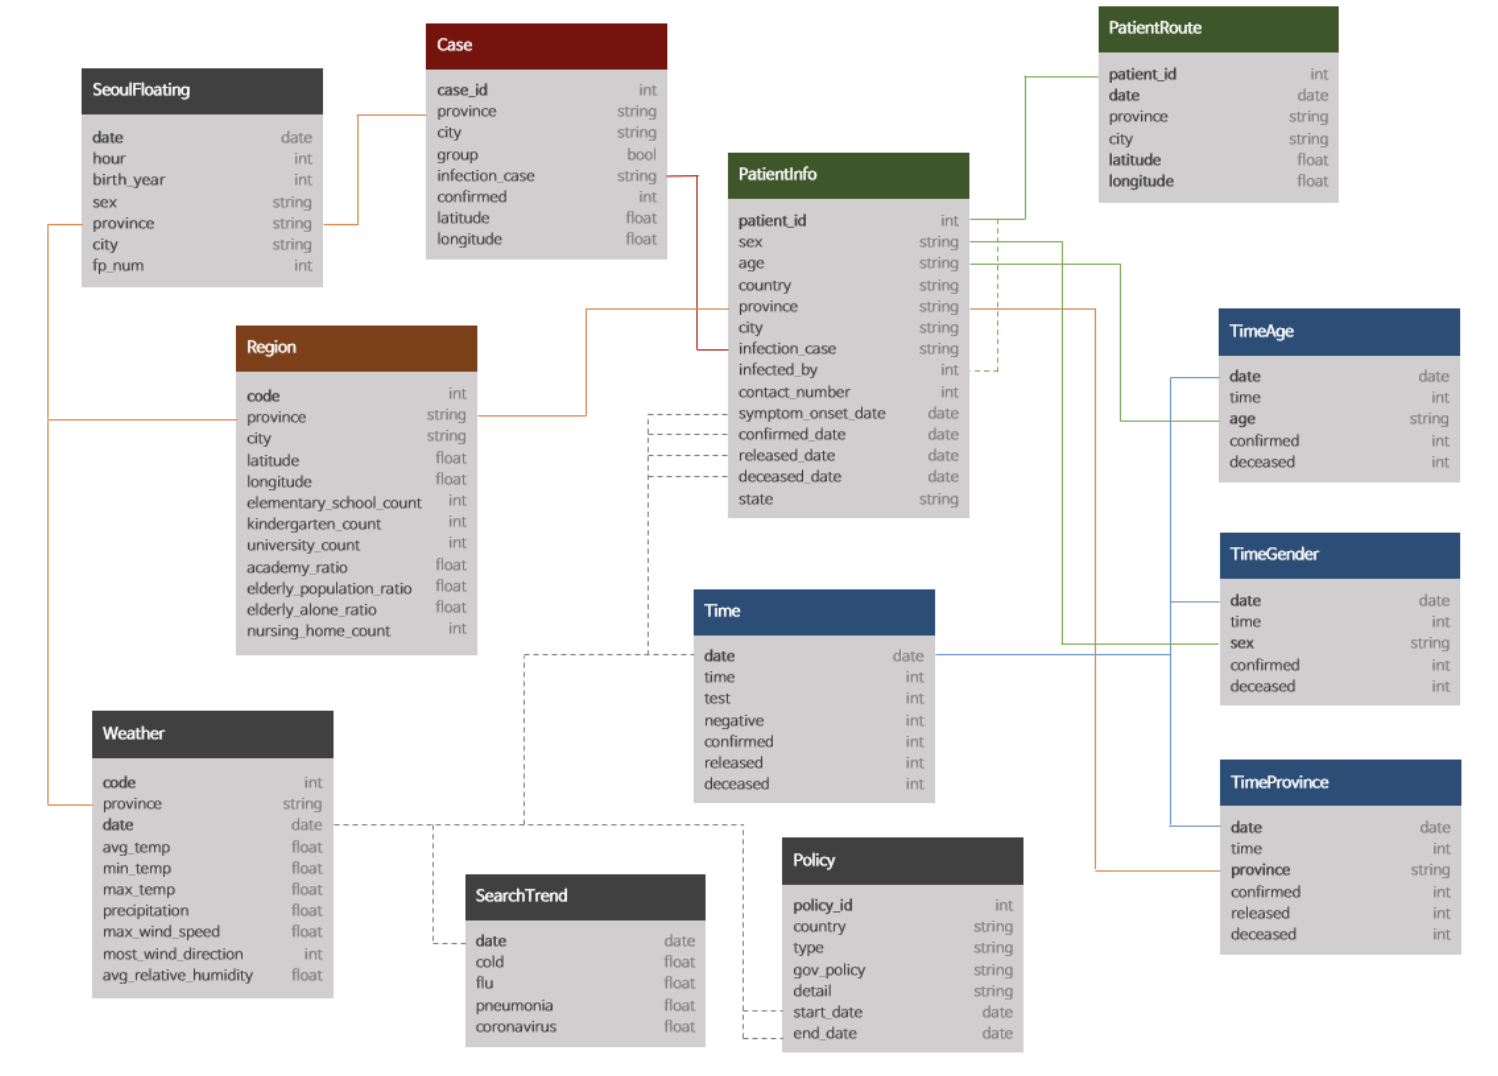

# Initial Setup

### Setting directory

In [1]:
import warnings
import sys
import os

os.chdir("/Users/lemuelrobinson/Documents/Turing_College/1_Sprint_4_Covid")

warnings.filterwarnings("ignore")

sys.path
sys.executable

sys.path.insert(
    0,
    r"/Users/lemuelrobinson/opt/anaconda3/pkgs/seaborn-0.12.2-py39hecd8cb5_0/lib/python3.9/site-packages",
)

### Importing modules and files

In [2]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from datetime import datetime as dt
from scipy import stats
import collections

ModuleNotFoundError: No module named 'seaborn'

### Inspecting the data

In [ ]:
# Create a dataframe for each csv file
case_df = pd.read_csv("Case.csv")
patient_info_df = pd.read_csv("PatientInfo.csv")
policy_df = pd.read_csv("Policy.csv")
region_df = pd.read_csv("Region.csv")
search_trend_df = pd.read_csv("SearchTrend.csv")
seoul_floating_df = pd.read_csv("SeoulFloating.csv")
time_df = pd.read_csv("Time.csv")
timeage_df = pd.read_csv("TimeAge.csv")
timegender_df = pd.read_csv("TimeGender.csv")
timeprovince_df = pd.read_csv("TimeProvince.csv")
weather_df = pd.read_csv("Weather.csv")

Before we do any manipulation or analysis of the data we'll check for duplicates and null values in case there are adjustments we'll have to make the data before going further, or any workarounds we'll need to do to make the most of the datasets we have here. Let's begin by defining the function we'll need to check for duplicates and missing values, and then we'll pass each of our imported dataframes to it in turn. 

In [ ]:
def duplicate_and_null_checker(list_of_dataframes):
    """Function takes list of dataframes as an input, checking that
    there are no null values or duplicates in each. It returns either a message
    confirming no duplicates and no nulls, or names of each dataframe requiring deeper investigation.
    """

    for i, df in enumerate(list_of_dataframes):
        if df.duplicated().any().sum() > 0:
            print(f"duplicates in {i}")
        if df.isnull().any().sum() > 0:
            print(f"nulls in {i}")


# Create list of all dataframes to pass to our helper function in the next cell
dataframe_list = [
    case_df,
    patient_info_df,
    policy_df,
    region_df,
    search_trend_df,
    seoul_floating_df,
    time_df,
    timeage_df,
    timegender_df,
    timeprovince_df,
    weather_df,
]

# Now that we have that function written, we'll see which need further investigation
duplicate_and_null_checker(dataframe_list)

nulls in 1
nulls in 2
nulls in 10


From the previous cell we see that we have null values in the indices corresponding to patient_info, policy, and weather. So we'll dig a little deeper into these in the next cells.

In [ ]:
patient_info_df.isna().sum()

patient_id               0
sex                   1122
age                   1380
country                  0
province                 0
city                    94
infection_case         919
infected_by           3819
contact_number        4374
symptom_onset_date    4475
confirmed_date           3
released_date         3578
deceased_date         5099
state                    0
dtype: int64

From the info table above, we can see that most of the columns have some missing data, which is pretty common for healthcare data collection. Some features like contact_number might not be as important for our analysis (i.e. contact number, but we might have to infer other datapoints like symptom_onset_date using data from the search trend dataframe or other tables

In [ ]:
policy_df.isna().sum()

policy_id      0
country        0
type           0
gov_policy     0
detail         2
start_date     0
end_date      37
dtype: int64

The info table shows that we are missing two values from the detail column, and there 37 missing from the end_date column. So we know when the Korean government started each policy, but not when or if the policies were phased out. We might be limited to measuring how strong the effect of each policy on infection rates was. For now though, we'll take a closer look at the last dataframe. 

In [ ]:
weather_df.isna().sum()

code                      0
province                  0
date                      0
avg_temp                 15
min_temp                  5
max_temp                  3
precipitation             0
max_wind_speed            9
most_wind_direction      29
avg_relative_humidity    20
dtype: int64

There are few missing values here, but this is more minor in relation to the other files we imported as dataframes. Considering that date and province are the columns that connect this data to other tables, it's good that these columns are complete. Now that this bit of due diligence is complete, let's get into the data. 

# Analysis

### Geographic baseline


In [ ]:
 import os

if not os.path.exists("images"):
    os.mkdir("images")

In [ ]:
# Mapbox density heatmap shows confirmed cases in Daegu and Seoul (Daegu has more)
pio.renderers.default = "vscode"
fig = go.Figure(
    go.Densitymapbox(lat=case_df.latitude, lon=case_df.longitude)
)
fig.update_layout(mapbox_style="open-street-map", mapbox_center_lon=180)
fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
fig.show()

fig.write_image("images/fig1.jpeg")

From the map above, it looks like we have a huge of number of cases in Seoul, some in Daegu, and a smattering of cases around the country.Let's print out tallies of cases by province to have a tabular view as well. 

In [ ]:
# Pull final date from Timeprovince for each region and use that as the total deceased number since the metric is cumulative
df = timeprovince_df.loc[timeprovince_df.date == timeprovince_df.date.max()].copy()

# Drop extraneous columns
patient_totals_by_region_df = df.drop(columns=["time", "date"])

# Set province as the index for the table
patient_totals_by_region_df = patient_totals_by_region_df.set_index("province")

# Sort confirmed patient numbers in descending order
patient_totals_by_region_df.sort_values(by="confirmed", ascending=False, inplace=True)
patient_totals_by_region_df

,confirmed,released,deceased
province,,,
Daegu,6906,6700,189
Gyeongsangbuk-do,1389,1328,54
Seoul,1312,985,7
Gyeonggi-do,1207,931,23
Incheon,341,290,1
Chungcheongnam-do,167,150,0
Busan,154,142,3
Gyeongsangnam-do,134,128,0
Daejeon,117,44,1


We can see here that we have a lot more cases in provinces outside of Daegu and Seoul, so we should look at each region graphically to determine when and where our spikes in cases are for each region. First we'll group case numbers by region by day, then we'll plot each region. 

In [ ]:
# Change confirmed_date column to datetime
patient_info_df["confirmed_date"] = pd.to_datetime(
    patient_info_df["confirmed_date"], errors="ignore"
)

# Group patient_info by region and confirmed_date
patient_date_region_df = (
    patient_info_df[["province", "patient_id", "confirmed_date"]]
    .groupby(["province", "confirmed_date"])
    .count()
    .sort_values(by=["province", "confirmed_date"])
)
patient_date_region_df

patient_id
province confirmed_date            
Busan    2020-02-21               2
         2020-02-22              14
         2020-02-23              22
         2020-02-24               6
         2020-02-25              11
...                             ...
Ulsan    2020-05-18               4
         2020-05-21               1
         2020-05-29               2
         2020-06-06               1
         2020-06-23               2

[904 rows x 1 columns]

In [ ]:
# Plot confirmed cases each day by province
df = patient_date_region_df.reset_index()
px.line(
    df,
    x="confirmed_date",
    y="patient_id",
    color="province",
    labels={"confirmed_date": "Confirmed Date", "patient_id": "Number of covid cases"},
    title="Number of cases per day by region",
)

This graph shows us the spread of cases across the provinces throughout the country, which fluctuate a decent amount at the beginning of pandemic. Futhermore, Gyeongsangbuk-do has the highest number of cases in a single day, recorded on March 5, 2020. This seems reasonable given that Gyeongsangbuk-do is South Korea's largest province. From this graph it seems like cases dwindled in mid-April nationwide, before appearing again in mid-May. <br> <br> Now that we have a general idea of the spread of cases across regions during this time, we should consider how international movement affects contagion before we can make recommendations--countries are not closed systems, so international movement could increase pandemic risks to the general population. 

## Cases from international movement

In [ ]:
# Isolate infection_case='overseas inflow'
inflows_df = patient_info_df.loc[patient_info_df["infection_case"] == "overseas inflow"]

# Group international inflow cases per day
inflow_cases_df = (
    inflows_df[["patient_id", "confirmed_date"]]
    .groupby(["confirmed_date"])
    .count()
    .sort_values(by=["confirmed_date"])
)

# Isolate the list of immigration controls and their start dates
immigration_procedures_df = policy_df.loc[
    policy_df.gov_policy == "Special Immigration Procedure"
]

# Impute patient_info_df.max() as the end date for these immigration controls
immigration_procedures_df.end_date = inflow_cases_df.index.max()

# Modify the detail column to read more clearly
immigration_procedures_df.detail = immigration_procedures_df.detail.map(lambda x: x[5:])
immigration_procedures_df.rename(columns={"detail": "country of origin"}, inplace=True)

# Plot cases by date
fig = px.line(
    inflow_cases_df,
    x=inflow_cases_df.index,
    y="patient_id",
    title="International inflow covid cases by day",
    labels={"confirmed_date": "Date", "patient_id": "Covid cases"},
)
fig.show()

# Plot Special immigration procedures by start date
fig2 = px.timeline(
    immigration_procedures_df,
    x_start="start_date",
    x_end="end_date",
    y="country of origin",
    color_discrete_sequence=px.colors.qualitative.Vivid,
    color="country of origin",
    title="COVID-19 Special Immigration Procedures by Start Date",
    hover_data=["country of origin"],
    labels={
        "start_date": "Policy Start Date",
        "end_date": "End Date",
        "country of origin": "Country of Origin",
    },
)

fig2.show()

# Show special immigration procedures df for reference
immigration_procedures_df

,policy_id,country,type,gov_policy,country of origin,start_date,end_date
4,5,Korea,Immigration,Special Immigration Procedure,China,2020-02-04,2020-06-30
5,6,Korea,Immigration,Special Immigration Procedure,Hong Kong,2020-02-12,2020-06-30
6,7,Korea,Immigration,Special Immigration Procedure,Macau,2020-02-12,2020-06-30
7,8,Korea,Immigration,Special Immigration Procedure,Japan,2020-03-09,2020-06-30
8,9,Korea,Immigration,Special Immigration Procedure,Italy,2020-03-12,2020-06-30
9,10,Korea,Immigration,Special Immigration Procedure,Iran,2020-03-12,2020-06-30
10,11,Korea,Immigration,Special Immigration Procedure,France,2020-03-15,2020-06-30
11,12,Korea,Immigration,Special Immigration Procedure,Germany,2020-03-15,2020-06-30
12,13,Korea,Immigration,Special Immigration Procedure,Spain,2020-03-15,2020-06-30
13,14,Korea,Immigration,Special Immigration Procedure,U.K.,2020-03-15,2020-06-30


This graph follows the same shape as our previous graphs of the overall case pool, from the immigration_procedures_df table we see that "special immigration procedures" i.e. quarantine policies for international travelers were enacted starting on Feb 2nd, expanding to all countries by Mar 19th. This predates the our huge spike in cases at the end of March. International cases crested on March 28 (9 days after the all-country-controls policy was launched), with a steep decline after, which suggests that in the medium term, these special immigration procedures had a positive effect in minimizing the number of cases from international inflows into the country. 



## Policy effects 

We'll first segment policies into timebound policies and stacked policies, which have no recorded end date in this dataset. From there, we'll create timelines of the policies and graph them alongside the patient counts for the country.

In [ ]:
# Create a dataframe of policies with both a start and end date
time_bound_policies_df = policy_df.dropna(subset=["start_date", "end_date"])

# Create a dataframe of policies without end dates and
# impute the last patient release date from patient_info to "cap" data reasonably
stacked_policies_df = policy_df.drop(index=time_bound_policies_df.index)
stacked_policies_df.end_date = pd.to_datetime(patient_info_df.released_date).max()

To create an ending point for the stacked_policies dataframe, I used the latest patient release date to give all datapoints a non-null end-date that makes sense for our dataset. This slight modification will make our timelines below computable. 

In [ ]:
fig = px.timeline(
    time_bound_policies_df,
    x_start="start_date",
    x_end="end_date",
    y="gov_policy",
    color_discrete_sequence=px.colors.qualitative.D3,
    color="type",
    title="COVID-19 Related Government Policies Completed in 2020",
    hover_data=["gov_policy", "detail"],
    labels={
        "start_date": "Start Date",
        "end_date": "End Date",
        "type": "Policy",
        "gov_policy": "Government Policy",
        "detail": "Description:",
    },
)
fig.update_yaxes(autorange="reversed")
fig.show()


fig2 = px.timeline(
    stacked_policies_df,
    x_start="start_date",
    x_end="end_date",
    y="gov_policy",
    color_discrete_sequence=px.colors.qualitative.D3,
    color="type",
    title="COVID-19 Related Government Policies Completed in 2020",
    hover_data=["gov_policy", "detail"],
    labels={
        "start_date": "Start Date",
        "end_date": "End Date",
        "type": "Policy",
        "gov_policy": "Government Policy",
        "detail": "Description:",
    },
)
fig2.show()

df = patient_info_df.groupby("confirmed_date").count().iloc[:, 0]
fig3 = px.line(
    df,
    x=df.index,
    y="patient_id",
    title="Confirmed Covid cases per day",
    labels={"confirmed_date": "Date", "patient_id": "Cases per day"},
    markers=True,
)
fig3.show()

Together these three graphs show the timeline of government led campaigns and administrative controls alongside case numbers. After the initial waves of cases in February-April, the government's social distancing campaign ended. However, high-density social spaces like karaoke bars and nightclubs remained open until May 8th/21st. <br><br> We cannot prove or disprove this hypothesis with the current data, but the uptick in cases around this time could point to social controls lifting at least partially during this time. Even though cases increased during this month, the government's diagnostic test kit distribution policy, mandatory self-quarantine policies, and social distancing messenging from the year appear to have helped keep cases from reaching March/April levels in the country. 

## Patient mortality

Now that we have a good overall view of covid patient prevalence across our dataset, we can assess patient mortality since that is an important indicator of pandemic response effectiveness within the country. We have deceased/released numbers in the timeprovince_df, timeage_df, and timegender_df. 

In [ ]:
df = timeage_df.copy()
df.set_index("age")
case_mortality = df[["confirmed", "age", "deceased"]].groupby(by="age").sum()
case_mortality["mortality_rate"] = case_mortality.deceased / case_mortality.confirmed

print(f"\nTotal deaths:{df.deceased.sum()}\nTotal cases: {df.confirmed.sum()}")

fig = px.line(
    case_mortality,
    x=case_mortality.index,
    y="mortality_rate",
    labels={"age": "Age", "mortality_rate": "Mortality rates"},
    title="Mortality rates by age",
    markers=True,
)

fig.show()
case_mortality.head(10)
print(f"\nTotal deaths: {df.deceased.sum()}\nTotal cases: {df.confirmed.sum()}")



Total deaths:25504
Total cases: 1261203



Total deaths: 25504
Total cases: 1261203


Mortality rates are zero for confirmed covid patients below the age of 30, but increases for each decade of life after that. Our data shows that we have 25,504 total deaths out of 1,261,203 total cases, so we can conclude that older patients are at higher risk. When thinking about transmissibility, we should also consider how cases can spread between groups of different ages as well. 

In [ ]:
fig = px.line(
    timegender_df,
    x="date",
    y="deceased",
    labels={"date": "Date", "deceased": "Deaths"},
    title="Mortality rates by gender (cumulative)",
    color="sex",
)
fig.show()

This figure shows that male deaths from covid are generally about 5-10 higher than female deaths on any given day--this may be miniscule enough a difference between these two samples to conclude we don't need to consider gender when analyzing covid deaths, but we'll verify before we proceed using a two sample t-test to gauge whether the means are the same.

In [ ]:
# T-test : Is the distribution of male and female mortalities the same?
#
# Store male and female mortalities in two different variables
male = timegender_df[timegender_df["sex"] == "male"]  # n=121
female = timegender_df[timegender_df["sex"] == "female"]  # n=121

# extract number deceased for each gender
male_deceased = male["deceased"]
female_deceased = female["deceased"]

# perform t-test:
t_stat, p_value = stats.ttest_ind(male_deceased, female_deceased)

# Interpret resulting values:
alpha = 0.05

if p_value < alpha:
    print(
        "Reject the null hypothesis; there is a significant difference between male and female deaths per day."
    )
else:
    print(
        "Fail to reject the null hypothesis. There is no significant difference between these two populations."
    )

Reject the null hypothesis; there is a significant difference between male and female deaths per day.


From our t-test above, we can conclude that the male and female mortality distributions are not the same, therefore we'll have to consider gender in our policy recommendations as we go. We might not be able to fully identify the correlations we need to speak more authoritatively about the reason(s) that these populations are different given the limitations of this dataset, but it's important to recognize nonetheless. Next let's plot deaths by province. 

In [ ]:
timeprovince_df.head()
df = (
    timeprovince_df[["province", "confirmed", "released", "deceased", "date"]]
    .groupby(by=["province", "date"])
    .sum()
)
# sns.lineplot(data=df,x='date',y='deceased');
df.head()

fig = px.line(
    timeprovince_df,
    x="date",
    y="deceased",
    color="province",
    title="Covid deaths by province",
)
fig.show()

fig2 = px.line(
    timeprovince_df,
    x="date",
    y="confirmed",
    color="province",
    title="Confirmed covid cases by province",
)
fig2.show()

As shown in our graphs before, Daegu has the lion's share of cases when compared to all other provinces in this timeframe, we'll need to dive further into what set Daegu apart from other regions. When comparing these two graphs side by side, we can see that cases in the region shot up before deaths did, which could point to demographic features specific to this region, such a higher proportion of young people or a higher density of treatment facilities for example. Next we'll take a look at group infections, i.e. clusters of simultaneous confirmed covid infections

In [ ]:
# Sum number of cluster cases by province
province_case_clusters_df = case_df.groupby("province").sum()
province_case_clusters_df.sort_values(by="province", inplace=True)


# Determine number of covid clusters per region
number_of_clusters = case_df.groupby("province").count()
number_of_clusters.sort_values(by="province", inplace=True)

# Cut out extraneous columns, we only want the case_id counts here
number_of_clusters.iloc[:, 0]

# Add the cluster counts to the province case clusters df as a column
province_case_clusters_df["number_of_clusters"] = number_of_clusters.iloc[:, 0]

# Pare down columns to just the confirmed cases and number of clusters
province_case_clusters_df = province_case_clusters_df.iloc[:, [4, 7]]

# Sort by decreasing case counts
province_case_clusters_df.sort_values(
    by="confirmed", ascending=False, inplace=True)
province_case_clusters_df

,confirmed,number_of_clusters
province,,
Daegu,6680,10
Gyeongsangbuk-do,1324,13
Seoul,1280,38
Gyeonggi-do,1000,22
Incheon,202,7
Chungcheongnam-do,158,8
Busan,156,10
Gyeongsangnam-do,132,12
Daejeon,131,10


Here we can see the basis for such high case numbers in Daegu compared to the other regions. Even though there were more clusters accounted for in Seoul, Daegu had such a massive number of cases overall, which drove the virus' spread there. For scale, we can see how marked the difference in magnitude was for this region compared to all others in the country. 

In [ ]:
# Plot bar charts of region for scale
fig = px.bar(
    province_case_clusters_df,
    x=province_case_clusters_df.index,
    y="confirmed",
    hover_data=["confirmed", "number_of_clusters"],
    color="confirmed",
    labels={"province": "Province", "confirmed": "Confirmed cases"},
    title="Number of mass Covid infections by region",
)
fig.update_layout(barmode="stack", xaxis={"categoryorder": "total descending"})
fig.show()

## Daegu: A Closer Look

Next, we should dive further into these clusters too see what other insights we can draw from the data. 

In [ ]:
# Subset case_df to Daegu only
daegu_cases_df = case_df.loc[case_df.province == "Daegu"]
daegu_cases_df.sort_values("confirmed", ascending=False)

,case_id,province,city,group,infection_case,confirmed,latitude,longitude
48,1200001,Daegu,Nam-gu,True,Shincheonji Church,4511,35.84008,128.5667
56,1200009,Daegu,-,False,contact with patient,917,-,-
57,1200010,Daegu,-,False,etc,747,-,-
49,1200002,Daegu,Dalseong-gun,True,Second Mi-Ju Hospital,196,35.857375,128.466651
50,1200003,Daegu,Seo-gu,True,Hansarang Convalescent Hospital,124,35.885592,128.556649
51,1200004,Daegu,Dalseong-gun,True,Daesil Convalescent Hospital,101,35.857393,128.466653
55,1200008,Daegu,-,False,overseas inflow,41,-,-
52,1200005,Daegu,Dong-gu,True,Fatima Hospital,39,35.88395,128.624059
53,1200006,Daegu,from other city,True,Itaewon Clubs,2,-,-
54,1200007,Daegu,from other city,True,Cheongdo Daenam Hospital,2,-,-


This table shows that hospitals and church are major covid contagion vectors for this region, which leads me to believe that we could be seeing similar trends in the other regions, even though Daegu is a standout. Let's do a regex search for churches across all regions to see how much of a pattern emerges. 

In [ ]:
# Expand regex to churches more generally
case_df.infection_case.unique()
mask = case_df.infection_case.str.contains("(c|C)hurch", regex=True)
index = case_df.infection_case[mask].index
case_df[["province", "city", "confirmed", "infection_case"]].iloc[index].sort_values(
    "confirmed", ascending=False
).head(15)

,province,city,confirmed,infection_case
48,Daegu,Nam-gu,4511,Shincheonji Church
145,Gyeongsangbuk-do,from other city,566,Shincheonji Church
90,Gyeonggi-do,Seongnam-si,67,River of Grace Community Church
5,Seoul,Guro-gu,41,Manmin Central Church
38,Busan,Dongnae-gu,39,Onchun Church
6,Seoul,from other city,36,SMR Newly Planted Churches Group
158,Gyeongsangnam-do,from other city,32,Shincheonji Church
9,Seoul,Gwanak-gu,30,Wangsung Church
96,Gyeonggi-do,from other city,29,Shincheonji Church
98,Gyeonggi-do,-,25,SMR Newly Planted Churches Group


Churches account for over 5000 over our cases across the country, which is pretty sizable. We should take a closer look at the infection case column to see if any other patterns emerge. I'll do a word frequency analysis for the country, and then tie our top recurring words or phrases back to the cases. We can identiy our top case types that way. 

In [ ]:
# Word frequency


# Split all phrases into word lists
word_lists = case_df.infection_case.map(lambda x: x.split())

# Collapse the whole series of lists into a single list
complete_word_list = []

for list in word_lists:
    for item in list:
        complete_word_list.append(item)

# Use the collections package to count the most common words
counts = collections.Counter(complete_word_list)

# Convert counts to pandas dataframe for easier use
infection_case_word_frequency_df = pd.DataFrame(
    counts.most_common(), columns=["words", "count"]
)

infection_case_word_frequency_df.loc[infection_case_word_frequency_df["count"] > 4, :]

,words,count
0,Church,30
1,overseas,17
2,inflow,17
3,etc,17
4,contact,16
5,with,16
6,patient,16
7,Shincheonji,15
8,Center,13
9,Hospital,12


Based on the frequency list here, we can see that churches, hospitals, overseas inflows, and contact with patient are our biggest cited reasons in this dataset. This to me suggests that these are our biggest infection vectors from the timeframe represented in the dataset, so let's do some quick math to see how many confirmed cases are represented by these 4 infection_case values compared to all others.  

In [ ]:
# First force all letters in the case_df column to lowercase to ease regex matching
df = case_df
df["infection_case"] = case_df.infection_case.str.lower()

# Set the regex for our big 4 vectors
re = "church|hospital|overseas inflow|contact with patient"

# Match to regex
mask = case_df.infection_case.str.contains(re, regex=True)
index = case_df.infection_case[mask].index

# Segment the cases by infection type
Big_4_df = df.iloc[index]
other_df = df.drop(index=Big_4_df.index)


In [ ]:
#  Create a boolean column
Big_4_df["church_boolean"] = case_df.infection_case.str.contains("church", regex=False)
Big_4_df["hospital_boolean"] = case_df.infection_case.str.contains(
    "hospital", regex=False
)
Big_4_df["overseas_boolean"] = case_df.infection_case.str.contains(
    "overseas inflow", regex=False
)
Big_4_df["contact_boolean"] = case_df.infection_case.str.contains(
    "contact with patient", regex=False
)

# Sum up big 4
Big_4_case_count = Big_4_df.confirmed.sum()

# Sum up all other cases
other_cases = other_df.confirmed.sum()

# Sum up the Big 4 cases in isolation
church_cases = Big_4_df.loc[Big_4_df.church_boolean == True].index
church_case_count = Big_4_df["confirmed"].loc[church_cases].sum()

hospital_cases = Big_4_df.loc[Big_4_df.hospital_boolean == True].index
hospital_case_count = Big_4_df["confirmed"].loc[hospital_cases].sum()


overseas_cases = Big_4_df.loc[Big_4_df.overseas_boolean == True].index
overseas_case_count = Big_4_df["confirmed"].loc[overseas_cases].sum()

contact_cases = Big_4_df.loc[Big_4_df.contact_boolean == True].index
contact_case_count = Big_4_df["confirmed"].loc[contact_cases].sum()

# Assemble tallies into dataframes
Big_4_comparison = pd.DataFrame(
    {
        "category": ["Big 4", "All other causes"],
        "Confirmed cases": [Big_4_case_count, other_cases],
    }
)

Big_4_breakdown = pd.DataFrame(
    {
        "Attribution": [
            "Church",
            "Hospital",
            "Overseas inflows",
            "Contact with patient",
        ],
        "Confirmed cases": [
            church_case_count,
            hospital_case_count,
            overseas_case_count,
            contact_case_count,
        ],
    }
)

In [ ]:
fig = px.pie(
    Big_4_comparison,
    values="Confirmed cases",
    names="category",
    title="Covid cause breakdown",
)
fig.show()


fig2 = px.bar(
    Big_4_breakdown,
    x="Attribution",
    y="Confirmed cases",
    title="Big 4 breakdown",
    color="Attribution",
    height=455,
)
fig2.update_layout(barmode="stack", xaxis={"categoryorder": "total descending"})
fig2.show()

75% of our cases come from the 4 causes listed in figure 2, and therefore should be the main focus of our policy recommendations. But before we get into those, we should see if there is any more insights that we can gather about the effect of public spaces on viral transmission. 

## Transmissibility and public spaces


We'll start by grouping covid cases at both provincial and city levels since datasets in our pool are organized at both levels of detail. From there we'll assess how our numerical values are correlated at both levels. 

In [ ]:
# Group cases by city and province in patient_info_df
df = patient_info_df.groupby(by=["province", "city"]).count()
df.sort_values(["province", "city"], inplace=True)

# Isolate patient id counts by province
province_city_cases_df = df[["patient_id"]].copy()

In [ ]:
# Groupby province and city
regional_cases_df = region_df.groupby(["province", "city"]).sum()

# Add our patient_id counts grouped by province and city
regional_cases_df["confirmed_cases"] = province_city_cases_df

# Check for null values in case some cities were missing from other dataset
#print(f'{regional_cases_df.confirmed_cases.isnull().sum()} observations missing out of {len(regional_cases_df.confirmed_cases)}.')

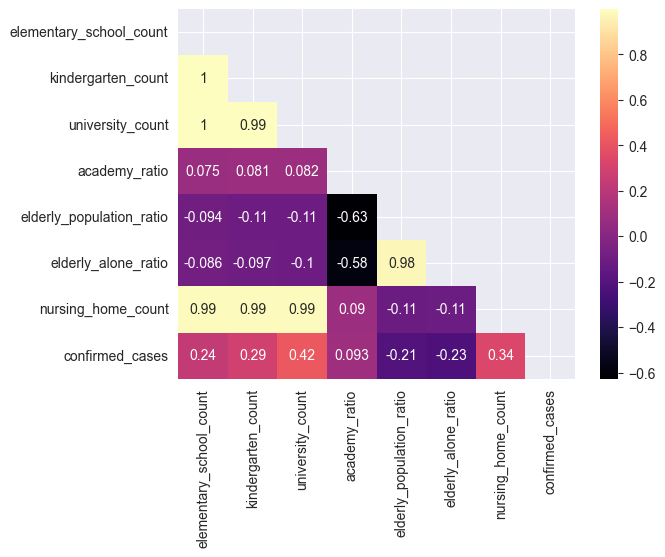

In [ ]:
# Copy regional_cases_df and drop code, latitude, and longitude
regional_cases_df_narrow = regional_cases_df.drop(
    columns=["code", "latitude", "longitude"]
)

# Check for correlations between confirmed_cases and the remaining numerical variables
corr = regional_cases_df_narrow.corr()
matrix = np.triu(corr)
sns.set_style("darkgrid")
sns.heatmap(corr, annot=True, mask=matrix, cmap="magma");

Looking at the confirmed_cases row at the bottom we can see that there aren't any super strong correlations for the numerical features here, but there is some correlation between the number of cases and the number of universities, likewise between the number of nursing homes and the number of cases. 

<Axes: >

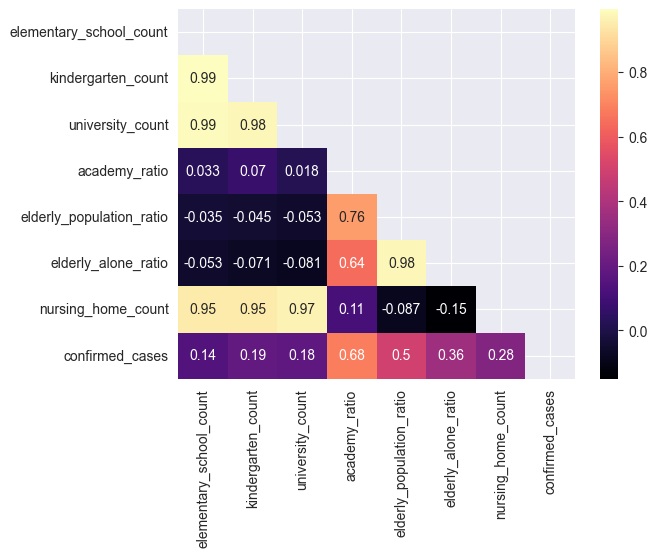

In [ ]:
# Aggregate regional cases to provincial level
province_cases_df = regional_cases_df.groupby("province").sum()
province_cases_df_narrow = province_cases_df.drop(
    columns=["code", "latitude", "longitude"]
)
sns.heatmap(province_cases_df_narrow.corr(), annot=True, mask=matrix, cmap="magma")

At the provincial level, the highest correlation is between academy ratio and confirmed cases, with elderly population ratio close behind. Interestingly, elderly_population_ratio correlation was negative at the city level, so it's an interesting example of Simpson's paradox. This means that we have a lurking confounding variable in there somewhere, most likely when we aggregate the data up to the provincial level. We'd need more data and possibly more sophisticated techniques to unravel that paradox fully, but for now can rely on the connection between mortality and age in this dataset to use in our policy recommendations.  

# Policy recommendations

Our analysis showed that the top four risk vectors for South Korea during an early-stage pandemic of this type were Church, contact with patients, overseas inflows, and hospitals. South Korea addressed these risks through a mix of government controls, social campaigns, public education, and distributing resources for more localized care. In this section, we'll run through recommendations for a country going through a similar public health crisis and highlight data that would need to be made available to both deepen our understanding and further clarify our recommendations. 

### Policy 1 : Temporarily closing religious gathering sites

In [ ]:
Big_4_breakdown.head()

,Attribution,Confirmed cases
0,Church,5536
1,Hospital,685
2,Overseas inflows,949
3,Contact with patient,1403


Our analysis showed that churches accounted for 5,536 cases alone--this number is even higher when we expand the regex to include pastors' groups, religious campus rallies, temples, and other religious gatherings/sites. Depending on the country, taking this measure early in a pandemic could be seen as anti-religious freedom, but nonetheless would help mitigate mortality rates, especially among the elderly. Statistically speaking, more religious segments of the population often trend older, so they are at higher risk of both transmission and death. Cluster and group infections also could mean the difference between a covid wave like those seen in Daegu, vs. waves seen in Gwangju, which had both fewer cluster infections and far fewer confirmed cases. 

### Policy 2: Closing down social commons where viruses could easily be spread

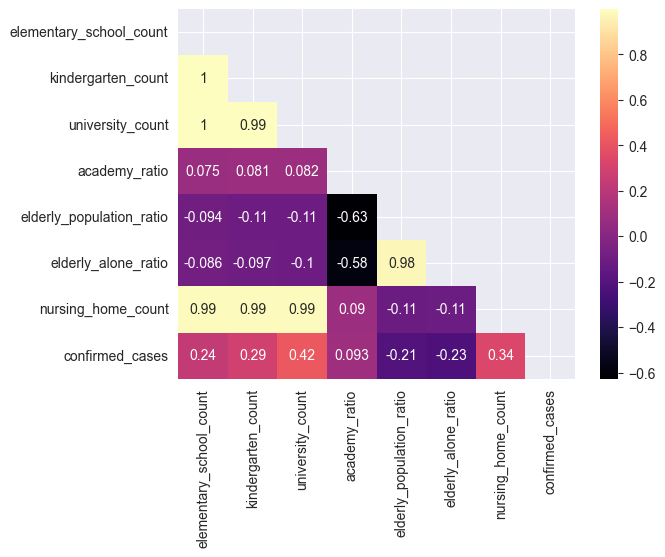

In [ ]:
corr = regional_cases_df_narrow.corr()
matrix = np.triu(corr)
sns.set_style("darkgrid")
sns.heatmap(corr, annot=True, mask=matrix, cmap="magma");

Academic spaces such as universities, kindergartens, and academies should be closed down immediately because these areas not only contain a high density of youth and college-aged students, but also are supported by economic activity, commuters, and staff from other swaths of the population. Though mortality is extremely low for patients under the age of 30, our data shows that nursing homes tend to be located near elementary schools, kindergartens, and universities so all academic activity has knock on effects for the elderly population. Though this may not be true for all countries, it is worth considering since higher elderly infections and mortality would affect hospital capacity, patient routing, and other public health considerations. 

### Policy 3: Immigrations and Customs Controls

The Coronavirus pandemic began outside of Korea, so almost all of their early cases came from tourists, returning national, or international commerce. Countries should employ testing, mandatory quarantine procedures, and collect data from people entering the country in order to mitigate viral transmission, because it both staunches case numbers in the early stages of the pandemic, but also buys the government time to mobilize domestic resources without having to fight a full-blown pandemic immediately.

### Policy 4: Emergency authorization of testing kits, mandatory quarantine, and social distancing campaigns

This policy refers to the mix of public messaging, resource mobilization, and government oversight that South Korea employed to great effect. Countries should emphasize community-based/country-based values to encourage mask wearing, social distancing, and other social conventions during an extraordinary time. The public should have ready access to testing equipment, centers, and treatment, as well as be informed on how to behave if they might have been exposed to a covid patient. The data shows that close contact with a patient is a major transmission vector, so educating the public on symptoms and instating mandatory quarantines helps mitigate contagion. 

### Policy 5: Instituting proper hospital/treatment procedures and providing a wide array of treatment options

Hospitals were a major cause of infections in our data, suggesting that either healthcare workers weren't properly protected, hospital protocols didn't protect non-Covid patients from contracting the virus from Covid patients, or a mix of the two. If treatment facilities are overloaded or there is a shortage of medical supplies, patient infections and mortality might increase. Further, if there are not enough treatment sites hospitals can be overcapacity which increases risk for both patients and healthcare workers. <br><br> Therefore, hospital treatment practices must be well designed, and potential patients must have access to clinics, makshift treatment areas, testing sites, and pharmacies outside of the hospitals. Following Policy 1 above, many academic or sports facilities could be converted to suit these ends. 

# Questions for further research

### How much time is there between exposure and symptom onset? Do patients experiences symptoms before or after they test positive? Do these answers differ by age and gender of the patient? 

To continue this research, we would need more data on patients broken down by age and gender. We were unable to calculate the delta between symptom onset and confirmed coronavirus infection due to the holes in our dataset, but can infer that the viral incubation period is between 9 and 14 days based on our international cases data and the 14-day quarantine period instituted by the government. I would like to analyze patient data to solidify these figures.

### Where were patients routed once they tested positive or presented symptoms? Which provinces in the country were underresourced, and how did these features affect patient treatment and mortality? 

Many countries have uneven distribution of resources, unequal service delivery, and wealth inequality. How would these features show up in our data, and how can governments anticipate these differences in service level while also responding to a once-in-a-generation crisis? My suspicion going through the data here is that Seoul had much more access to good healthcare options, very high quality service delivery, and resources to make it through this period of the coronavirus pandemic without seeing the case numbers that Daegu did. According to the map above, Seoul's population is times larger than that of Daegu but saw 19% of the cases seen in that province. Since Seoul is the capital, there may be infrastructure and logistical reasons for this that may be instructive for other countries. 

### What is the true correlation between elderly population ratio and the number of confirmed cases? 

Our analysis showed that when grouped at the city level, confirmed_cases had a negative correlation to elderly_population_ratio, but a positive correlation when grouped at the province level. This suggests that we have at least one confounding variable that would elucidate these relationships, but would need more data regarding the elderly population and service delivery at both city and provincial levels. We might also have to employ other data techniques to properly explore unique challenges to that demographic group. 


# Conclusion

South Korea's experience at this stage of the Coronavirus pandemic is instructive for small, well-connected countries at a similar level of economic development. Because of its close economic ties with China and geographic proximity to the epicenter of the pandemic, it had an earlier experience with the virus also, that may be instructive for countries who face similar challenges at the very beginning of a viral pandemic. Countries should consider how their topography, demographic composition, and level of development in their healthcare infrastructure allows them to reproduce South Korea's successes during this time.